<strong>Aluno</strong>: Victor São Paulo Ruela



In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_iris, load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Treinamento perceptron simples
### Exercício 1

Inicialmente, define-se a função geradora dos dados, conforme indicado no enunciado.

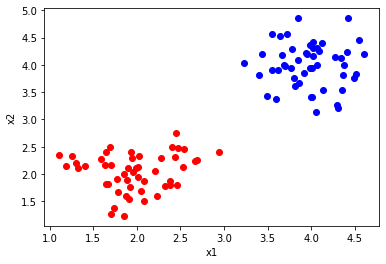

In [5]:
def func_normal(mean, std, label, dim=2, N=50):
    xc = np.random.normal(loc=mean, scale=std, size=(N, len(mean)))
    data_xc = pd.DataFrame(xc, columns=['x1','x2'])
    data_xc['y'] = label
    return data_xc
    
def plot_func(data):
    t_class0 = data['y'] == 0
    t_class1 = data['y'] == 1

    fig, ax = plt.subplots()

    ax.scatter(data.loc[t_class0, 'x1'],
                data.loc[t_class0, 'x2'], color='red')
    ax.scatter(data.loc[t_class1, 'x1'], data.loc[t_class1, 'x2'], color='blue')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    return fig, ax

data_c1 = func_normal([2,2], [0.4, 0.4], 0)
data_c2 = func_normal([4,4], [0.4, 0.4], 1)

data = pd.concat([data_c1, data_c2], ignore_index=True)

fig, _ = plot_func(data)
fig.show()

Em seguida, é necessário implementar a função para treinamento e predição do Perceptron simples. 

In [6]:
# Implementação do perceptron simples para um problema de classificação binário
class LinearPerceptron:
    def __init__(self, eta=0.01, max_epochs=100):
        self.eta = eta
        self.max_epochs = max_epochs

    def predict(self, x, w):
        N, _ = x.shape
        x_aug = np.hstack((-np.ones((N, 1)), x))
        u = x_aug @ w
        return u, 1.0 * (u >= 0)

    def train(self, x_train, y_train):
        # initialize the weight matrix
        N, n = x_train.shape
        x_aug = np.hstack((-np.ones((N, 1)), x_train))

        wt = np.random.rand(n+1) - 0.5
        wk = []
        n_epochs = 0
        e_vec = []

        while(n_epochs < self.max_epochs):
            # generate random indexes order
            xseq = np.arange(N)
            np.random.shuffle(xseq)
            error_array = []

            for i_rand in xseq:
                yhati = 1.0 * ((x_aug[i_rand, :] @ wt) >= 0)
                ei = y_train[i_rand] - yhati
                # calculate step size
                dw = self.eta * ei * x_aug[i_rand, :]
                # update weight vector
                wt = wt + dw
                
                wk.append(wt)
                error_array.append(ei ** 2)

            # increment number of epochs
            n_epochs = n_epochs + 1
            e_vec.append(np.sum(error_array) / N)

        return wt, e_vec, wk

Em seguida, é criada uma rotina que recebe um conjunto de dados de entrada e desenha a sua superfície de separação conforme a sugestão do enunciado do exercício.

In [27]:
def plot_decision_boundary(data, plot_error=False):
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    x = np.arange(0, 6, step=0.1)
    y = np.arange(0, 6, step=0.1)

    xx, yy = np.meshgrid(x, y)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    
    # train the model
    model = LinearPerceptron()
    y_train = data['y'].to_numpy()
    x_train = data[['x1', 'x2']].to_numpy()
   
    w, e, wk = model.train(x_train, y_train)

    # make predictions for the grid
    _, yhat = model.predict(grid, w)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    ax1.contourf(xx, yy, zz, cmap='Set2')
   
    t_class0 = data['y'] == 0
    t_class1 = data['y'] == 1
    ax1.scatter(data.loc[t_class0, 'x1'],
                data.loc[t_class0, 'x2'], color='red')
    ax1.scatter(data.loc[t_class1, 'x1'], data.loc[t_class1, 'x2'], color='blue')
    ax1.set_xlabel('x1')
    ax1.set_ylabel('x2')

    surf = ax2.plot_surface(xx, yy, zz, cmap='jet')
    #fig.colorbar(surf, ax=ax2)

    fig.show()

    # calculate training error
    if(plot_error == True):
        fig, ax = plt.subplots()
        ax.plot(e)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Error')

    # print final training error
    print(f'Model Accuracy: {100 * np.sum(y_train == model.predict(x_train, w))/len(y_train)} %')

Model Accuracy: 100.0 %


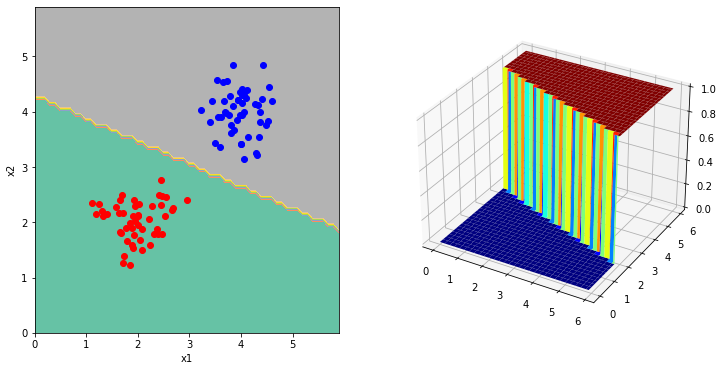

In [28]:
# Linear perceptron
plot_decision_boundary(data)

## Exercício 2


In [29]:
# split the data
def train_test_split(X, y, ratio=0.7):
    N = len(y)
    x_rand = np.arange(N)
    np.random.shuffle(x_rand)
    i_split = int(np.floor(ratio * N))

    x_train, x_test = x_rand[:i_split], x_rand[i_split:]
    return X[x_train,:], y[x_train], X[x_test,:], y[x_test]
    
data_c1 = func_normal([2,2], [0.4, 0.4], 0, N=200)
data_c2 = func_normal([4,4], [0.4, 0.4], 1, N=200)
data = pd.concat([data_c1, data_c2], ignore_index=True)

X, y = data[['x1','x2']].to_numpy(), data['y'].to_numpy()

X_train, y_train, X_test, y_test = train_test_split(X, y)
model = LinearPerceptron()
# train the model on training set
w, e, wk = model.train(X_train, y_train)
# make predictions for the teste set
_, yhat = model.predict(X_test, w)
# print the accuracy
print(f'Acurácia: {100 * np.sum(y_test == model.predict(X_test, w))/len(y_test)} %')
# print the confusion matrix
print(f'Matriz de Confusão: \n {confusion_matrix(y_test, yhat)}')

Acurácia: 100.0 %
Matriz de Confusão: 
 [[56  0]
 [ 0 64]]


## Exercício 3

In [30]:
# load the iris data
X_iris, y_iris = load_iris(as_frame=True, return_X_y=True)

In [32]:
# create the modified target
y_target = y_iris.map(lambda x: 1 if x >=1 else 0)

In [63]:
def iris_experiment(X, y, N=100, print_iterations=False, print_results=True):
    # split the data
    X_train_iris, y_train_iris, X_test_iris, y_test_iris = train_test_split(X, y)

    model = LinearPerceptron(max_epochs=100)
    error_results = []
    for i in range(N):
        # train the model on training set
        w_iris, _, _ = model.train(X_train_iris, y_train_iris)
        # make predictions for the teste set
        _, yhat_iris = model.predict(X_test_iris, w_iris)
        # accuracy
        accuracy = 100 * np.sum(y_test_iris == model.predict(X_test_iris, w_iris))/len(yhat_iris)
        error_results.append(100 - accuracy)
        if(print_iterations):
            # print the accuracy
            print(f'Acurácia: {accuracy} %')
            # print the confusion matrix
            #print(f'Matriz de Confusão: \n {confusion_matrix(y_test_iris, yhat_iris)}')
            sns.heatmap(confusion_matrix(y_test_iris, yhat_iris),annot=True,fmt="d",cbar=False)
            plt.title('Matriz de Confusão')

    if(print_results == True):
        plt.plot(error_results, 'ko-')
        plt.xlabel('Iteração')
        plt.ylabel('Erro (%)')
        print(f'Variância: {np.var(error_results)}')


Acurácia: 100.0 %


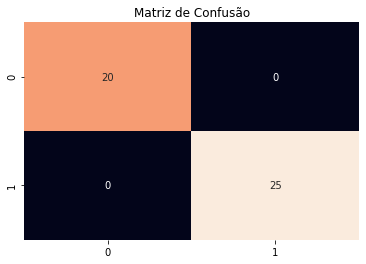

In [64]:
iris_experiment(X_iris.to_numpy(), y_target.to_numpy(), 1, True, False)

Variância: 0.32148148148148353


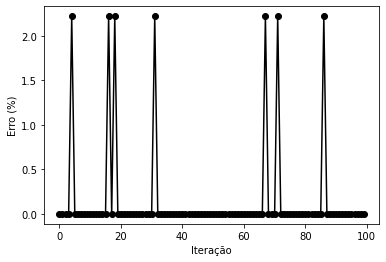

In [37]:
iris_experiment(X_iris.to_numpy(), y_target.to_numpy(), 100)

## Exercício 4

In [39]:
# load the breast cancer data
X_bc, y_bc = load_breast_cancer(return_X_y = True)

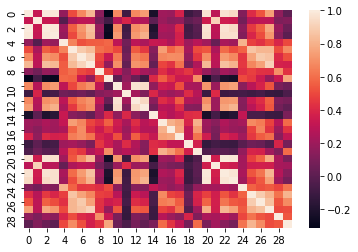

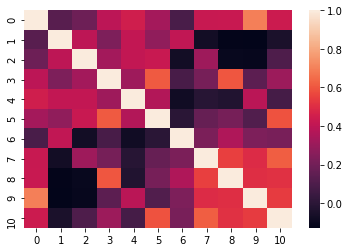

In [40]:
# preprocessing
# normalize data
scaler = MinMaxScaler()
X_bc_norm = scaler.fit_transform(X_bc)

# remove highly correlated features
X_bc_df = pd.DataFrame(X_bc_norm)
fig, ax = plt.subplots()
sns.heatmap(X_bc_df.corr(), ax=ax)
fig.show()

corr_matrix = X_bc_df.corr().abs()

sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                  .stack()
                  .sort_values(ascending=False))

cols_to_remove = []
for index, value in sol.items():
    if(value > 0.7):
        cols_to_remove.append(index[0])

cols_to_remove = np.unique(cols_to_remove)
cols_mask = np.isin(np.arange(X_bc_norm.shape[1]) , cols_to_remove, invert=True)
X_bc_norm_final = X_bc_norm[:, cols_mask]

fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(X_bc_norm_final).corr(), ax=ax)
fig.show()

In [61]:
def breast_cancer_experiment(X, y, N=30, print_iterations=False, print_results=True):
    # split the data
    X_train, y_train, X_test, y_test= train_test_split(X, y)
    
    model = LinearPerceptron(max_epochs=100)
    accuracy_results = []
    for i in range(N):
        # train the model on training set
        w, _, _ = model.train(X_train, y_train)
        # make predictions for the teste set
        _, yhat = model.predict(X_test, w)
        # accuracy
        accuracy = 100 * np.sum(y_test == model.predict(X_test, w))/len(yhat)
        accuracy_results.append(accuracy)
        if(print_iterations):
            # print the accuracy
            print(f'Acurácia: {accuracy} %')
            # print the confusion matrix
            # print(f'Matriz de Confusão: \n {confusion_matrix(y_test, yhat)}')
            sns.heatmap(confusion_matrix(y_test, yhat),annot=True,fmt="d",cbar=False)
            plt.title('Matriz de Confusão')

    if(print_results == True):
        plt.plot(accuracy_results, 'ko-')
        plt.xlabel('Iteração')
        plt.ylabel('Acurácia (%)')
        print(f'Média: {np.mean(accuracy_results)}')
        print(f'Desvio padrão: {np.std(accuracy_results)}')

Acurácia: 88.88888888888889 %


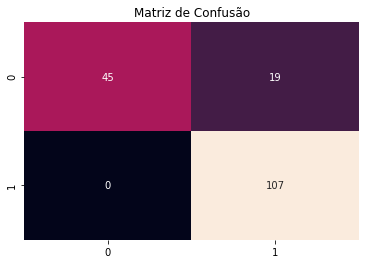

In [62]:
breast_cancer_experiment(X_bc_norm_final, y_bc, 1, True, False)

Média: 90.17543859649123
Desvio padrão: 2.281950974918035


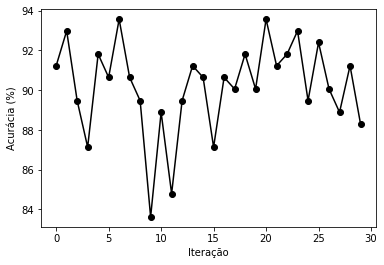

In [43]:
# reduced features
breast_cancer_experiment(X_bc_norm_final, y_bc, 30)

Média: 95.86744639376217
Desvio padrão: 1.1191189157432604


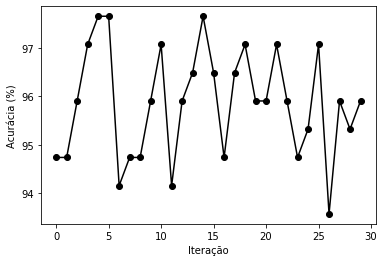

In [44]:
# all features
breast_cancer_experiment(X_bc_norm, y_bc, 30)